# GAN Modell zur Generierung von synthetischen Daten


In [11]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import Util.data_check


## Data Preparation

In [2]:
# set random seed for reproducibility
np.random.seed(42)

# Daten laden
data = pd.read_csv('./../Data/preprocessed_df_v2.csv')  # Pfad zu Ihren Daten

# Extrahiere Participant und Test IDs
participant_ids = data['participant_id']
test_ids = data['test_id']

# Entferne die ID-Spalten aus den Daten, die skaliert werden sollen
data_for_scaling = data.drop(['participant_id', 'test_id'], axis=1)

# Auffüllen von NaN-Werten mit dem Mittelwert der jeweiligen Spalte
data_for_scaling = data_for_scaling.fillna(data_for_scaling.mean())

# Überprüfen auf NaN-Werte in den Daten
assert not np.any(np.isnan(data_for_scaling)), "Daten enthalten NaN-Werte"

# Daten skalieren
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data_for_scaling)

# Die skalierten Daten wieder mit den IDs zusammenführen
data_scaled = pd.DataFrame(data_scaled, columns=data_for_scaling.columns)
data_scaled['participant_id'] = participant_ids
data_scaled['test_id'] = test_ids

# die hinzugefügten IDs an den Anfang der Daten verschieben
cols = data_scaled.columns.tolist()
cols = cols[-2:] + cols[:-2]
data_scaled = data_scaled[cols]


print(data_scaled.head())

# GAN-Parameter
latent_dim = 100
data_dim = data_scaled.shape[1] - 2  # Nicht die ID-Spalten mitzählen

   participant_id  test_id  test_duration    mental  physical  temporal  \
0               1        1      -0.993814 -0.894737 -1.000000 -0.789474   
1               1        2      -0.995240 -0.052632 -0.473684 -0.578947   
2               1        3      -0.983375  1.000000 -0.894737  0.473684   
3               1        4      -0.992565  0.157895 -0.789474 -0.157895   
4               2        1      -0.991575 -0.684211 -0.894737 -0.684211   

   performance    effort  frustration    mean  ...  blinkrate  fixationrate  \
0    -0.473684 -0.578947    -0.894737 -0.7300  ...  -0.874455      0.072029   
1     0.052632 -0.789474    -0.578947 -0.2925  ...  -1.000000     -0.364152   
2     0.684211  0.789474    -0.684211  0.4575  ...  -0.586037     -0.289947   
3     0.052632 -0.684211    -0.578947 -0.2100  ...  -0.889323      0.044196   
4    -0.789474 -0.684211    -0.789474 -0.7100  ...  -0.898826     -0.479368   

   blinkrate_rel  blinkrate_rel_pct  fixationrate_rel  fixationrate_rel_pc

## GAN Definition

In [3]:
# Generator-Modell
def build_generator(latent_dim, data_dim, num_participants, num_tests):
    # Eingabe für die IDs
    participant_input = tf.keras.layers.Input(shape=(1,))
    test_input = tf.keras.layers.Input(shape=(1,))
    latent_input = tf.keras.layers.Input(shape=(latent_dim,))
    
    # Embedding für kategorielle Eingaben
    participant_embedding = tf.keras.layers.Embedding(num_participants, 5)(participant_input)
    test_embedding = tf.keras.layers.Embedding(num_tests, 5)(test_input)
    
    # flatten
    participant_flat = tf.keras.layers.Flatten()(participant_embedding)
    test_flat = tf.keras.layers.Flatten()(test_embedding)
    
    # Kombinieren der Eingaben
    combined_input = tf.keras.layers.concatenate([latent_input, participant_flat, test_flat])
    
    # Weiter mit dem vorherigen Modell
    x = tf.keras.layers.Dense(128)(combined_input)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.2)(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.2)(x)
    x = tf.keras.layers.Dense(512)(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.2)(x)
    output = tf.keras.layers.Dense(data_dim, activation='tanh')(x)
    
    model = tf.keras.Model(inputs=[latent_input, participant_input, test_input], outputs=output)
    return model

# Diskriminator-Modell
def build_discriminator(data_dim, num_participants, num_tests):
    # Eingabe für die Daten
    data_input = tf.keras.layers.Input(shape=(data_dim,))
    participant_input = tf.keras.layers.Input(shape=(1,))
    test_input = tf.keras.layers.Input(shape=(1,))

    # Embedding für kategoriale Eingaben
    participant_embedding = tf.keras.layers.Embedding(num_participants, 5)(participant_input)
    test_embedding = tf.keras.layers.Embedding(num_tests, 5)(test_input)
    
    # Flachlegen der Embeddings
    participant_flat = tf.keras.layers.Flatten()(participant_embedding)
    test_flat = tf.keras.layers.Flatten()(test_embedding)
    
    # Kombinieren der Eingaben
    combined_input = tf.keras.layers.concatenate([data_input, participant_flat, test_flat])
    
    # Weiter mit dem vorherigen Modell
    x = tf.keras.layers.Dense(512)(combined_input)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.2)(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.2)(x)
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.2)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=[data_input, participant_input, test_input], outputs=output)
    return model

# GAN-Modell
def build_gan(generator, discriminator):
    # Stelle sicher, dass der Diskriminator beim Trainieren des GANs nicht aktualisiert wird
    discriminator.trainable = False
    
    # Eingaben für das GAN-Modell
    latent_input = tf.keras.layers.Input(shape=(generator.input_shape[0][1],))
    participant_input = tf.keras.layers.Input(shape=(1,))
    test_input = tf.keras.layers.Input(shape=(1,))
    
    # Generator und Diskriminator verbinden
    generated_data = generator([latent_input, participant_input, test_input])
    gan_output = discriminator([generated_data, participant_input, test_input])
    
    # GAN-Modell erstellen
    model = tf.keras.Model(inputs=[latent_input, participant_input, test_input], outputs=gan_output)
    return model

In [4]:
# Hyperparameter
learning_rate_discriminator = 0.00005
learning_rate_generator = 0.0001

num_participants = data_scaled['participant_id'].nunique()
num_tests = 4

# Modelle mit konditionierten Inputs erstellen
generator = build_generator(latent_dim, data_dim, num_participants, num_tests)
discriminator = build_discriminator(data_dim, num_participants, num_tests)

# Kompilieren des Diskriminators
discriminator.compile(optimizer=Adam(learning_rate_discriminator, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

# Diskriminator trainierbar auf False setzen für GAN
discriminator.trainable = False

# GAN-Modell erstellen
gan = build_gan(generator, discriminator)
gan.compile(optimizer=Adam(learning_rate_generator, 0.5), loss='binary_crossentropy')

# Vorbereiten der Eingaben für das Training
participant_ids = data_scaled['participant_id'].values
test_ids = data_scaled['test_id'].values

# Die tatsächlichen skalierten Trainingsdaten ohne die ID-Spalten
real = data_scaled.drop(['participant_id', 'test_id'], axis=1).values
real_labels = np.ones((real.shape[0], 1))
fake_labels = np.zeros((real.shape[0], 1))

2024-06-24 09:04:11.723858: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-06-24 09:04:11.723882: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-06-24 09:04:11.723886: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-06-24 09:04:11.724052: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-24 09:04:11.724065: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Training

In [6]:
# GAN-Training
epochs = 10 # just for testing 
batch_size = 32

d_losses = []
g_losses = []

for epoch in range(epochs):
    idx = np.random.randint(0, real.shape[0], batch_size)
    real_samples = real[idx]
    real_participant_ids = participant_ids[idx]
    real_test_ids = test_ids[idx]
    
    # Umwandlung in Tensoren mit festgelegter Form
    real_participant_ids_tensor = tf.constant(real_participant_ids, dtype=tf.int32, shape=(batch_size, 1))
    real_test_ids_tensor = tf.constant(real_test_ids, dtype=tf.int32, shape=(batch_size, 1))
    
    # Zufälliges Rauschen und Fake-Daten generieren
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_samples = generator.predict([noise, real_participant_ids, real_test_ids])
    
    # Diskriminator trainieren
    d_loss_real = discriminator.train_on_batch([real_samples, real_participant_ids, real_test_ids], real_labels[:batch_size])
    d_loss_fake = discriminator.train_on_batch([fake_samples, real_participant_ids, real_test_ids], fake_labels[:batch_size])
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # GAN trainieren (das Ziel ist, den Diskriminator zu täuschen)
    g_loss = gan.train_on_batch([noise, real_participant_ids, real_test_ids], real_labels[:batch_size])
    
    # Verluste speichern
    d_losses.append(d_loss[0])
    g_losses.append(g_loss)
    
    # Fortschritt ausgeben
    if (epoch + 1) % 1 == 0:  # Ersetzt 1000 durch 1 für das Debugging
        print(f"{epoch + 1} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}%] [G loss: {g_loss}]")


print("Training abgeschlossen!")
print(f"{epochs} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}%] [G loss: {g_loss}]")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1 [D loss: 0.8255053758621216, acc.: 47.2104549407959%] [G loss: [array(0.8256604, dtype=float32), array(0.8256604, dtype=float32), array(0.47173998, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
2 [D loss: 0.8255453109741211, acc.: 47.20941781997681%] [G loss: [array(0.8257002, dtype=float32), array(0.8257002, dtype=float32), array(0.47173077, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
3 [D loss: 0.8255907297134399, acc.: 47.20839262008667%] [G loss: [array(0.82574445, dtype=float32), array(0.82574445, dtype=float32), array(0.47172162, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4 [D loss: 0.8256332874298096, acc.: 47.212153673172%] [G loss: [array(0.82578653, dtype=float32), array(0.82578653, dtype=float32), array(0.47176033, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
5 [D loss: 0.8256770372390747, acc.: 47.2015917301178%] [G loss: [array(0.82582957, dtype=float32), array(0.82582957, dtype=float32), array(0

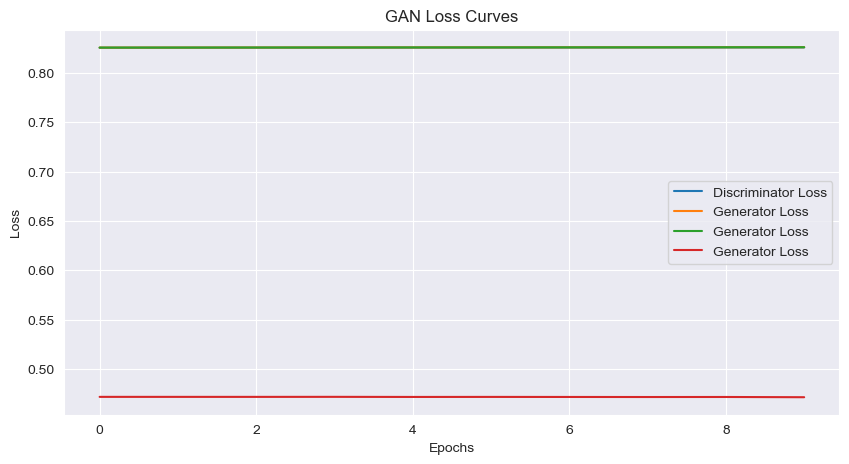

In [7]:
# Verlustkurven plotten
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("GAN Loss Curves")
plt.show()

## Daten generieren

In [8]:
# Anzahl der zusätzlichen Teilnehmer, die generiert werden sollen
num_additional_participants = 250  # 250 Participants, jeder führt 4 Tests durch, ergibt 1000 Punkte
num_tests_per_participant = 4

# Höchste vorhandene Participant ID ermitteln
max_participant_id = data['participant_id'].max()

# Neue Participant IDs generieren
new_participant_ids = np.arange(max_participant_id + 1, max_participant_id + 1 + num_additional_participants)

# Test IDs für jeden neuen Teilnehmer festlegen (1, 2, 3, 4)
new_test_ids = np.tile(np.arange(1, num_tests_per_participant + 1), num_additional_participants)

# Erweiterung der Participant IDs, um die Test IDs zu matchen
extended_participant_ids = np.repeat(new_participant_ids, num_tests_per_participant)

# Zufälliges Rauschen generieren
noise = np.random.normal(0, 1, (num_additional_participants * num_tests_per_participant, latent_dim))

# IDs in Tensoren umwandeln und sicherstellen, dass die Form definiert ist
participant_ids_tensor = tf.constant(extended_participant_ids.reshape(-1, 1), dtype=tf.int32)
test_ids_tensor = tf.constant(new_test_ids.reshape(-1, 1), dtype=tf.int32)

# Fake-Daten generieren
synthetic_data_scaled = generator.predict([noise, participant_ids_tensor, test_ids_tensor])

# Die generierten Daten zurückskalieren auf den ursprünglichen Wertebereich
synthetic_data = scaler.inverse_transform(synthetic_data_scaled)

# IDs zu den generierten Daten hinzufügen
synthetic_data_with_ids = np.hstack((extended_participant_ids.reshape(-1, 1), new_test_ids.reshape(-1, 1), synthetic_data))

# Die generierten Daten mit den Originaldaten kombinieren
augmented_data = np.vstack((data.values, synthetic_data_with_ids))

# In ein TensorFlow-Dataset umwandeln
dataset = tf.data.Dataset.from_tensor_slices(augmented_data)

print("Original Data Shape:", data.shape)
print("Synthetic Data Shape:", synthetic_data_with_ids.shape)
print("Augmented Data Shape:", augmented_data.shape)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
Original Data Shape: (188, 22)
Synthetic Data Shape: (1000, 22)
Augmented Data Shape: (1188, 22)


In [9]:
# Ausgewählte Datenpunkte plotten
synthetic_data_with_ids = pd.DataFrame(synthetic_data_with_ids, columns=data.columns)
print("Synthetic Data")
print(synthetic_data_with_ids[:25])

# Speichern der generierten Daten
synthetic_data_with_ids.to_csv('./../Data/synthetic_data.csv', index=False)  

print("Synthetic Data saved successfully!")

Synthetic Data
    participant_id  test_id  test_duration     mental  physical   temporal  \
0             48.0      1.0    6960.020508   9.613403  5.029708  99.638931   
1             48.0      2.0    6316.867188  13.943038  5.021353  99.731888   
2             48.0      3.0    6532.742188  13.357273  5.089178  99.658165   
3             48.0      4.0    6760.148926   8.196253  5.030238  99.884933   
4             49.0      1.0    6739.944336   7.111403  5.041908  99.854141   
5             49.0      2.0    6689.917480   9.019872  5.071089  99.383644   
6             49.0      3.0    6334.348633   8.125255  5.014615  99.838333   
7             49.0      4.0    7155.065430   5.444887  5.000249  99.991577   
8             50.0      1.0    6652.916016   9.010962  5.066704  99.922607   
9             50.0      2.0    6816.358887   7.572626  5.017381  99.855286   
10            50.0      3.0    6344.180176   8.913953  5.055685  99.782326   
11            50.0      4.0    6508.137695   8.10

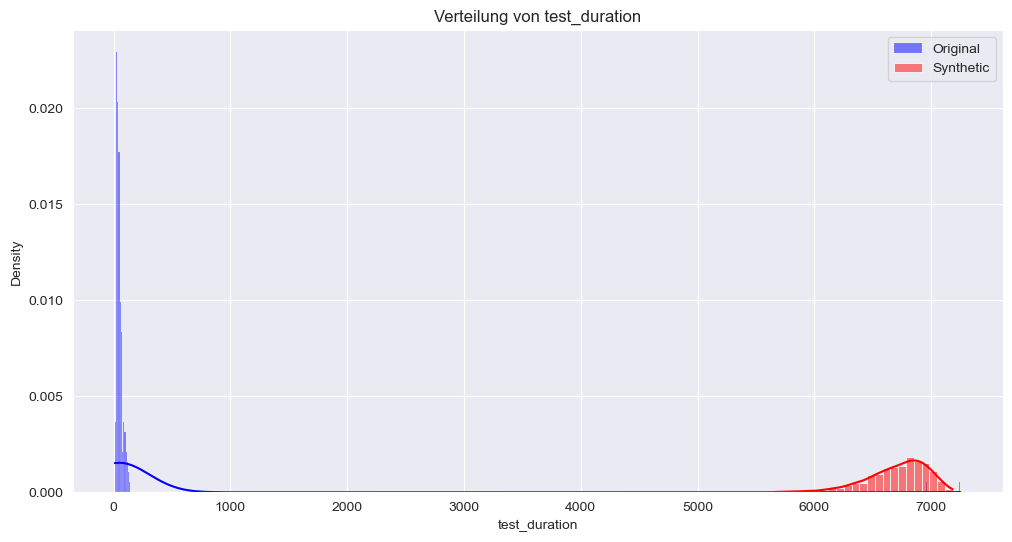

Normalitätstest für test_duration:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für test_duration:
Statistik = 455.9993030574431, p-Wert = 3.5687834933447824e-101
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).



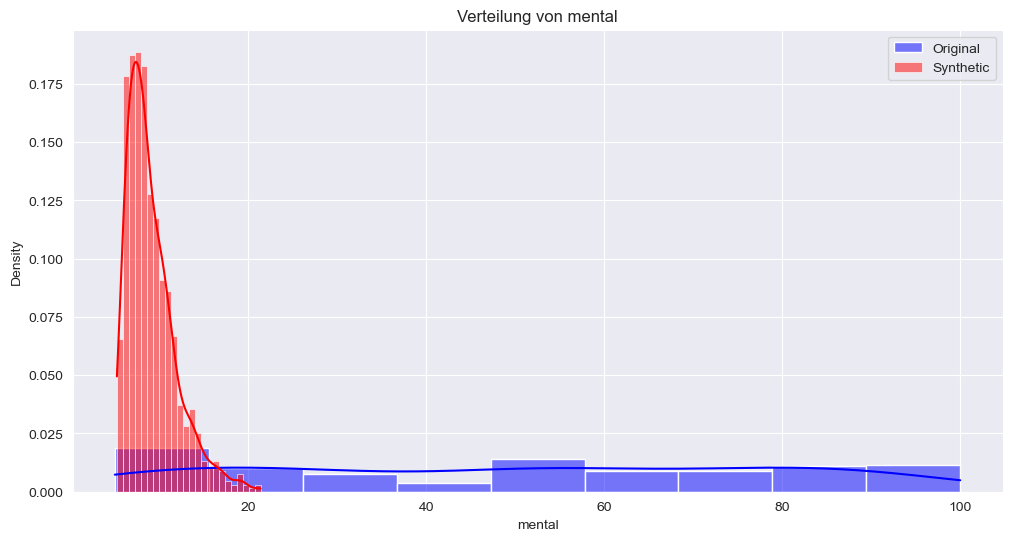

Normalitätstest für mental:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für mental:
Statistik = 316.47121818411136, p-Wert = 8.502750879581205e-71
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).



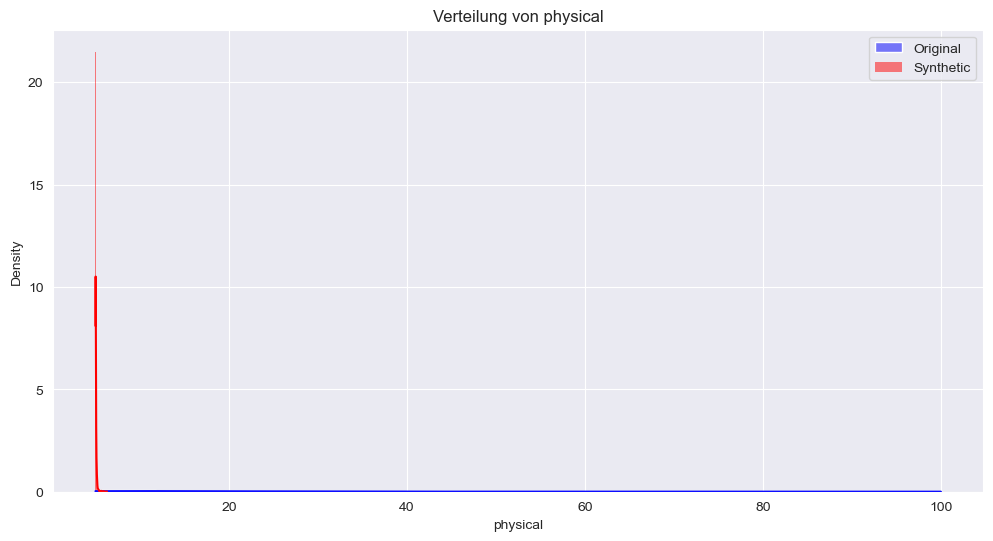

Normalitätstest für physical:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für physical:
Statistik = 94.71124349360981, p-Wert = 2.20284423937692e-22
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).



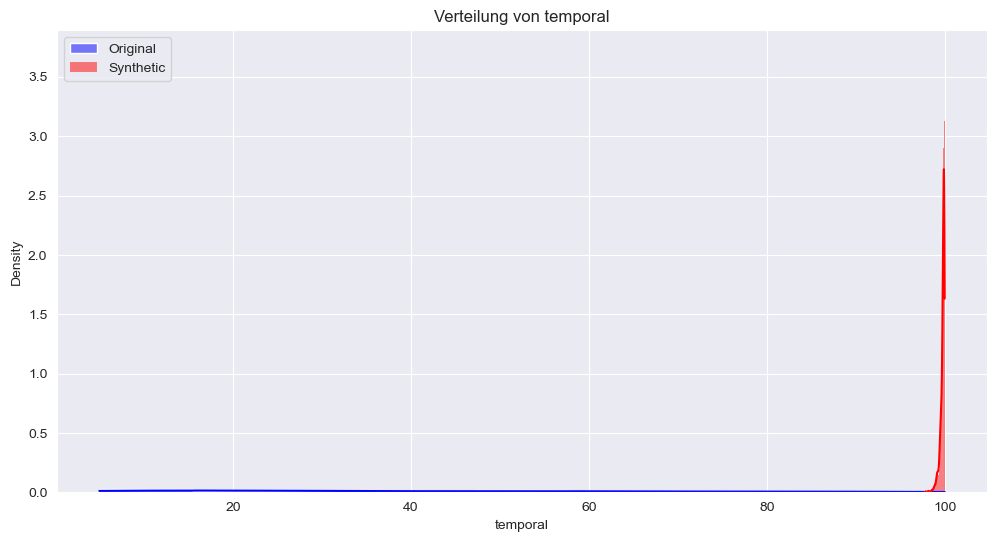

Normalitätstest für temporal:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für temporal:
Statistik = 444.56724131880526, p-Wert = 1.0976149243729346e-98
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).



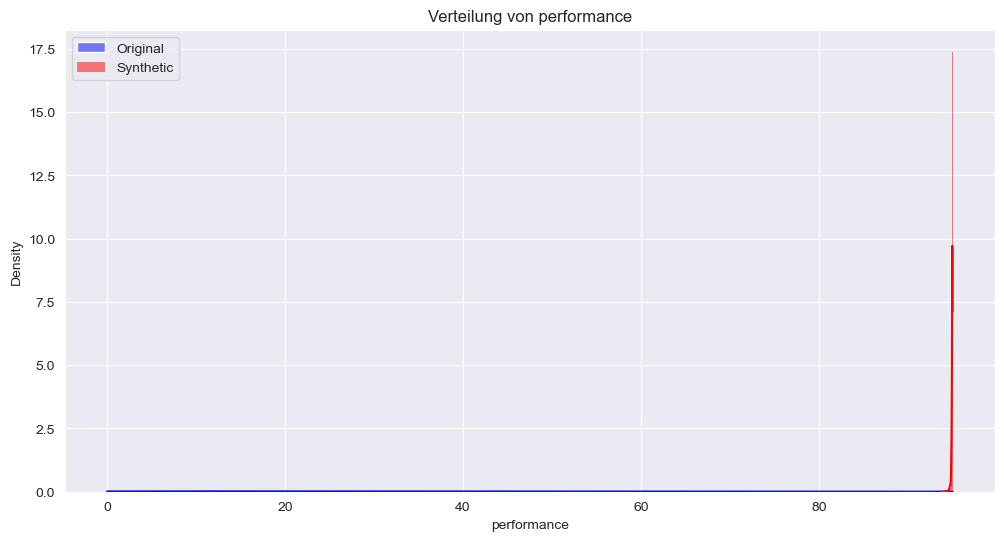

Normalitätstest für performance:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für performance:
Statistik = 454.38846752193035, p-Wert = 7.999701703187065e-101
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).



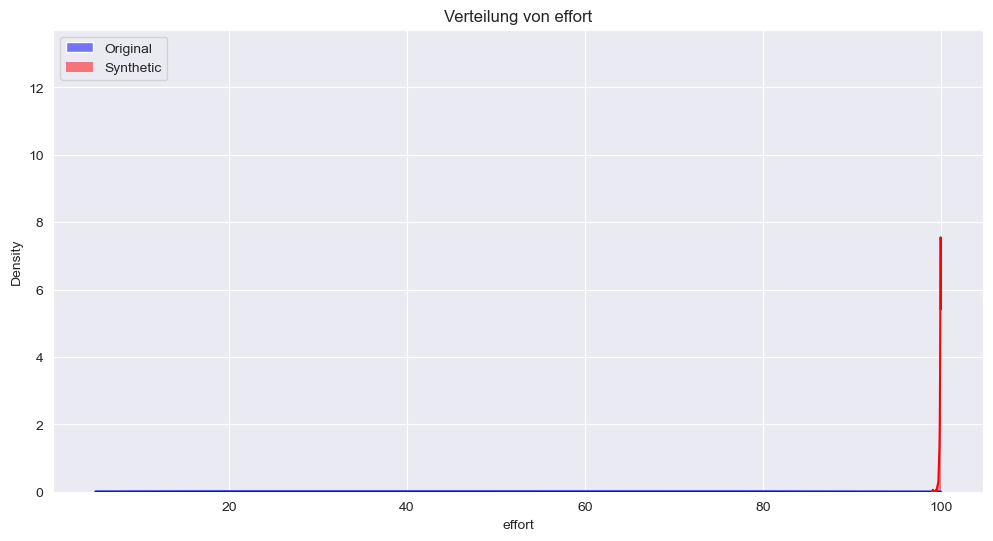

Normalitätstest für effort:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für effort:
Statistik = 434.84356076748173, p-Wert = 1.4345015244650518e-96
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).



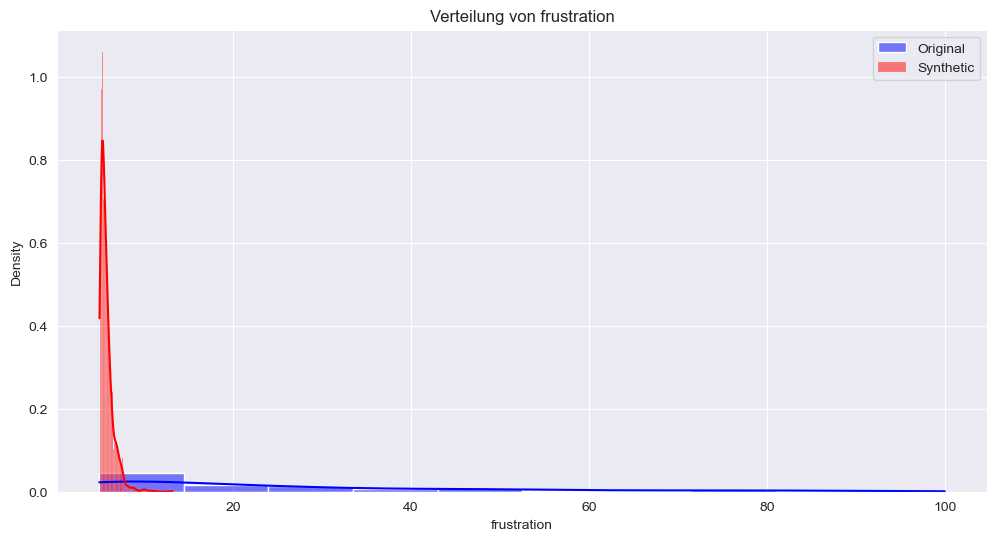

Normalitätstest für frustration:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für frustration:
Statistik = 61.68439064250179, p-Wert = 4.0316370812447136e-15
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).



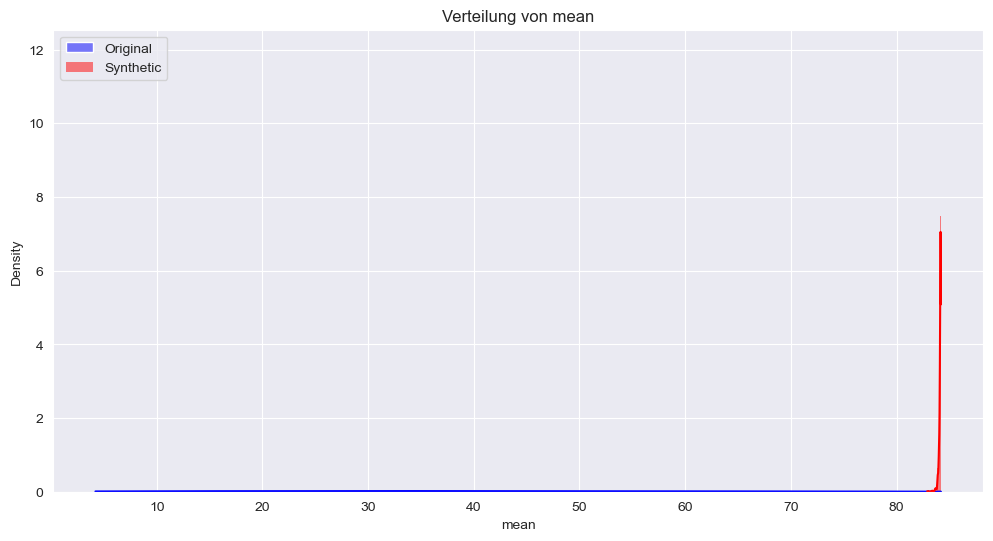

Normalitätstest für mean:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für mean:
Statistik = 464.27001567660494, p-Wert = 5.658109290747848e-103
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).



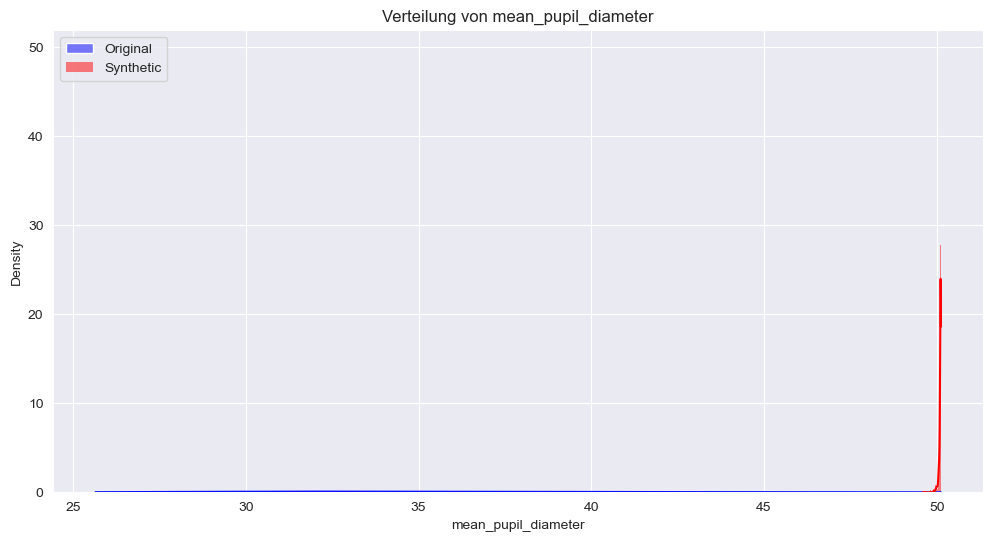

Normalitätstest für mean_pupil_diameter:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für mean_pupil_diameter:
Statistik = 464.30949355134914, p-Wert = 5.54728444260611e-103
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).



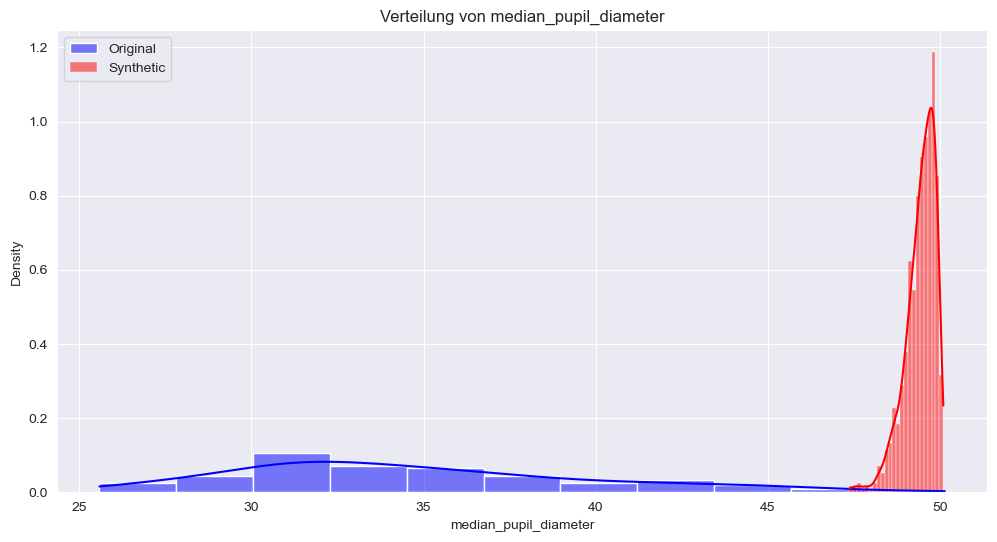

Normalitätstest für median_pupil_diameter:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für median_pupil_diameter:
Statistik = 460.2642561857214, p-Wert = 4.210993705234319e-102
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).



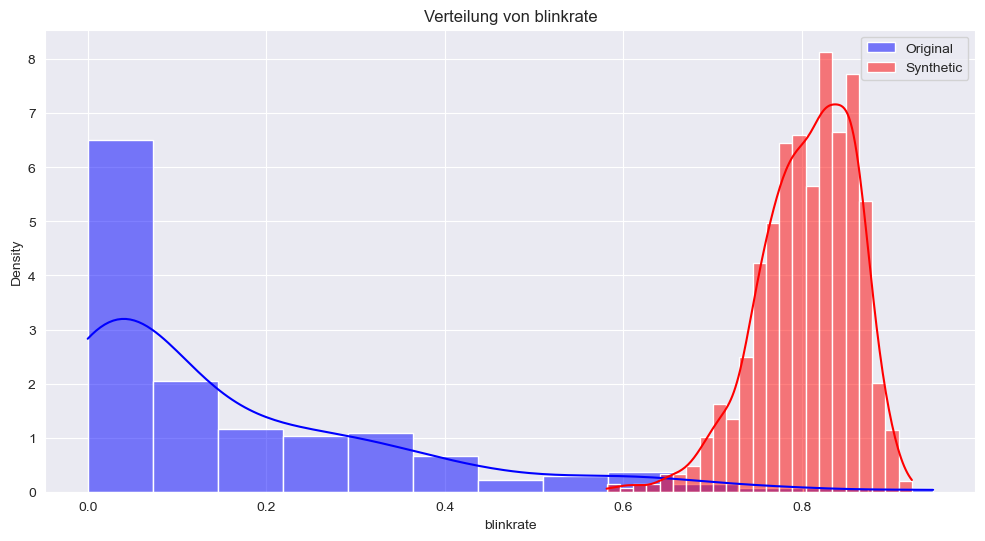

Normalitätstest für blinkrate:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für blinkrate:
Statistik = 457.55055343081614, p-Wert = 1.640348795394713e-101
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).



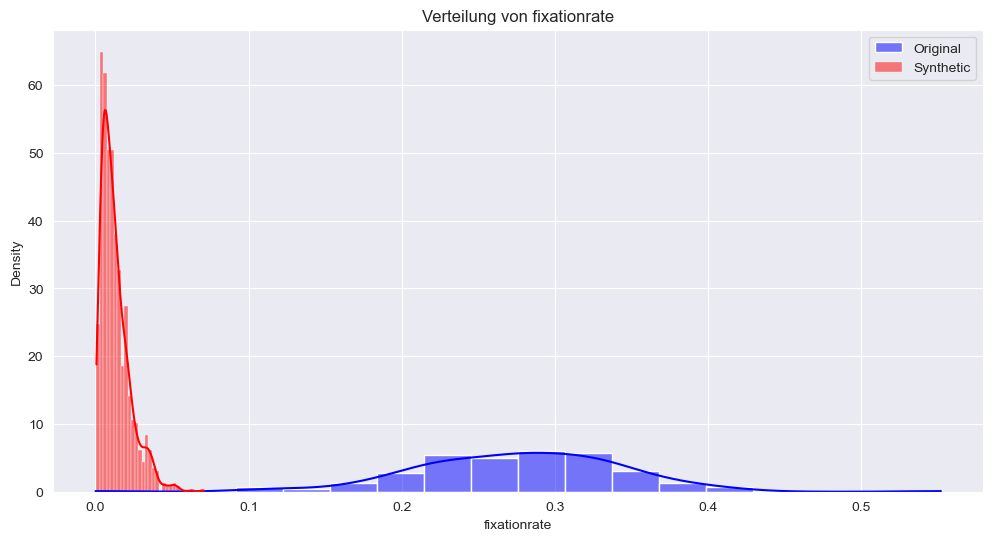

Normalitätstest für fixationrate:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für fixationrate:
Statistik = 464.30936727459846, p-Wert = 5.54763545136175e-103
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).



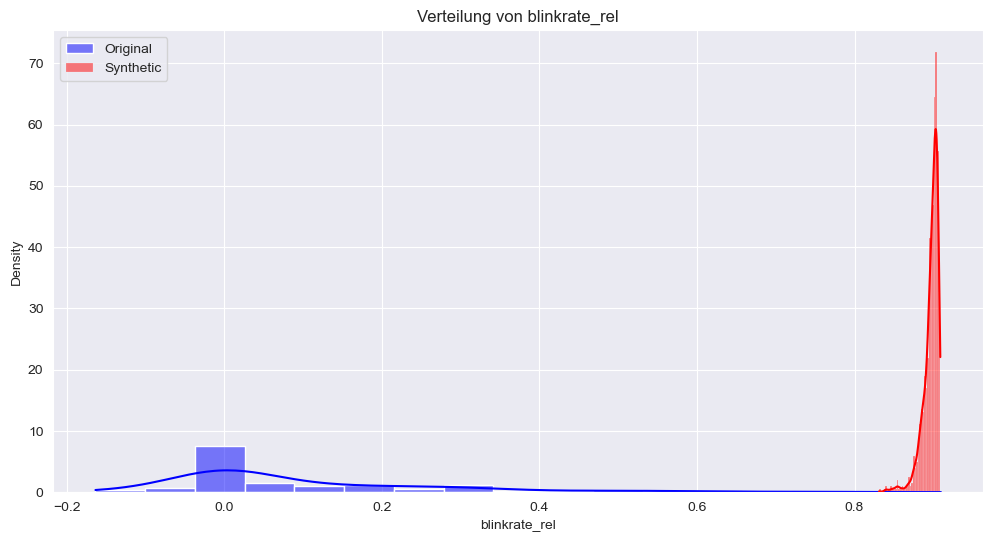

Normalitätstest für blinkrate_rel:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für blinkrate_rel:
Statistik = 464.3606429449396, p-Wert = 5.406916558811933e-103
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).



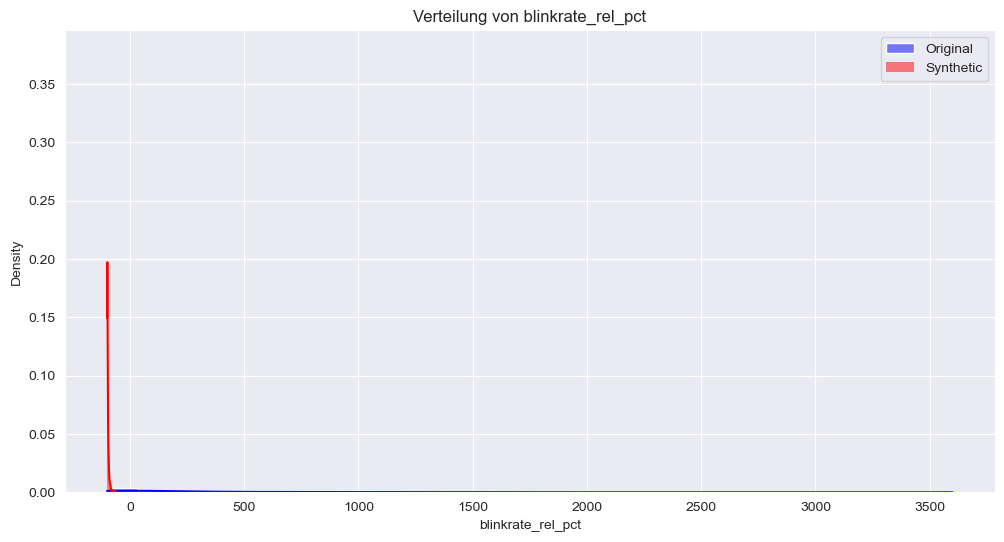

Normalitätstest für blinkrate_rel_pct:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für blinkrate_rel_pct:
Statistik = nan, p-Wert = nan
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).



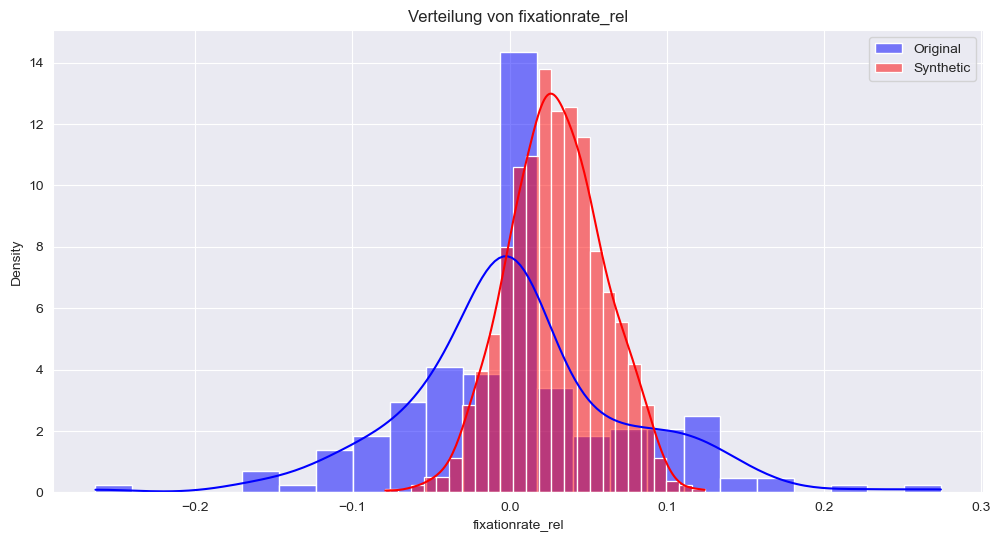

Normalitätstest für fixationrate_rel:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Normalverteilt
Kruskal-Wallis H-Test für fixationrate_rel:
Statistik = 60.68977333445132, p-Wert = 6.68163536130492e-15
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).



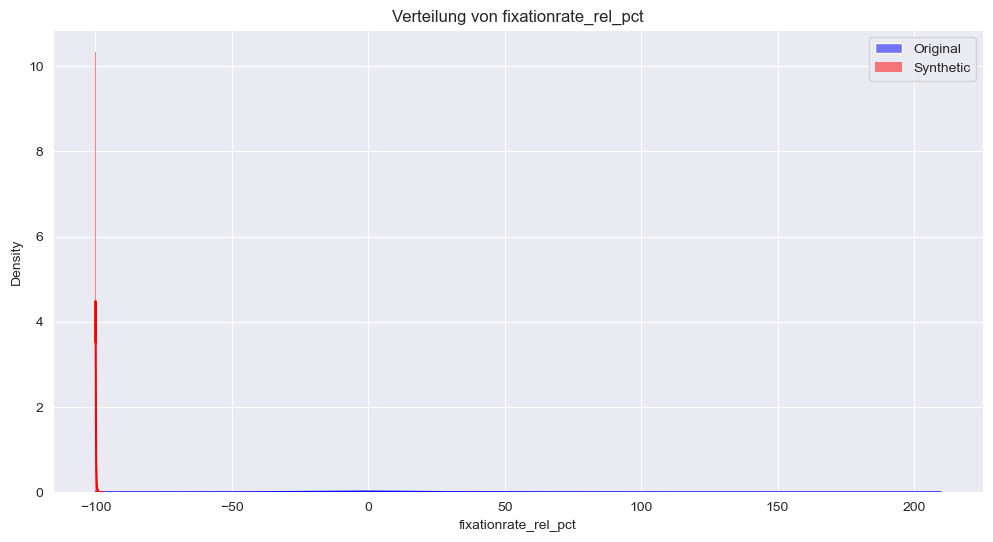

Normalitätstest für fixationrate_rel_pct:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für fixationrate_rel_pct:
Statistik = 464.338166798295, p-Wert = 5.468154370930385e-103
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).



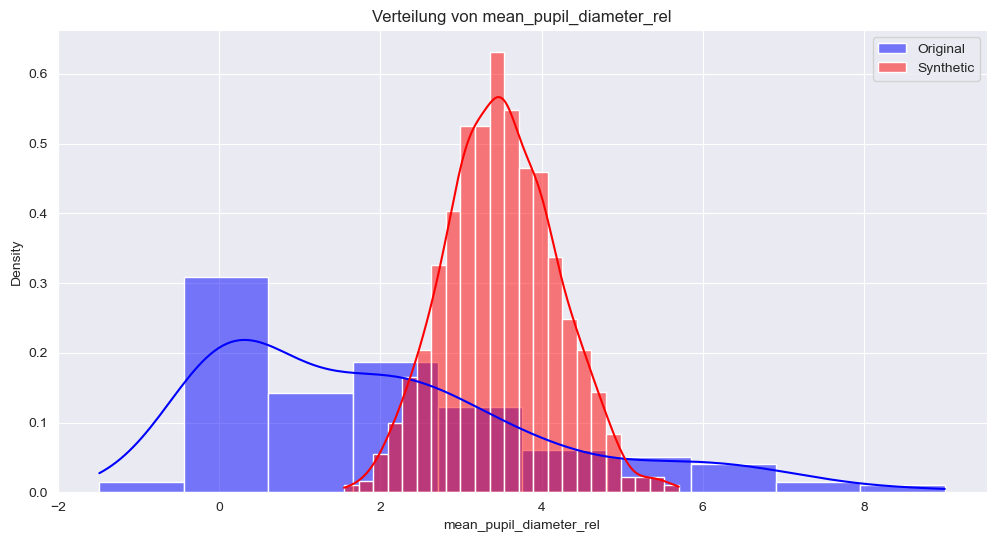

Normalitätstest für mean_pupil_diameter_rel:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Normalverteilt
Kruskal-Wallis H-Test für mean_pupil_diameter_rel:
Statistik = 150.56761749036636, p-Wert = 1.3028474546208278e-34
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).



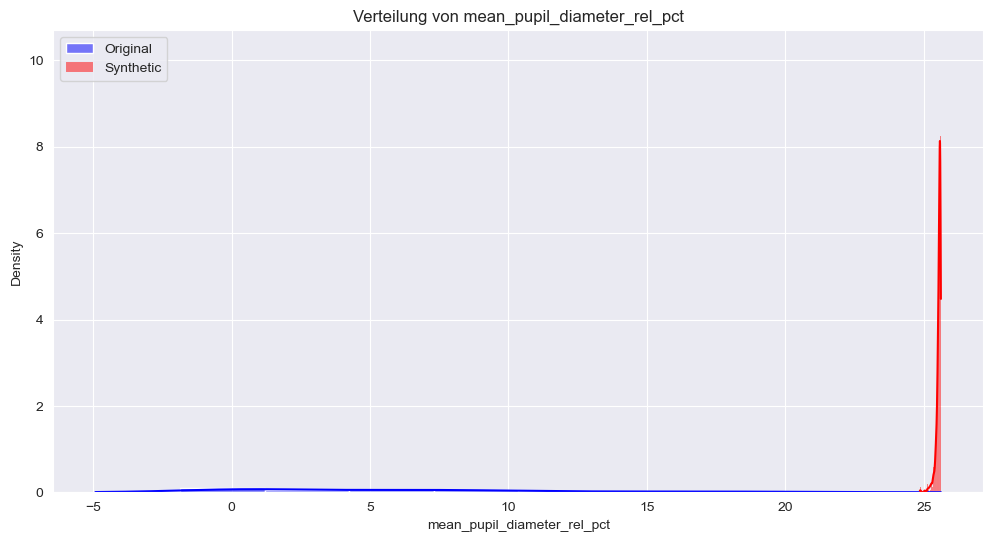

Normalitätstest für mean_pupil_diameter_rel_pct:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für mean_pupil_diameter_rel_pct:
Statistik = 464.33811528430283, p-Wert = 5.468295518010556e-103
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).



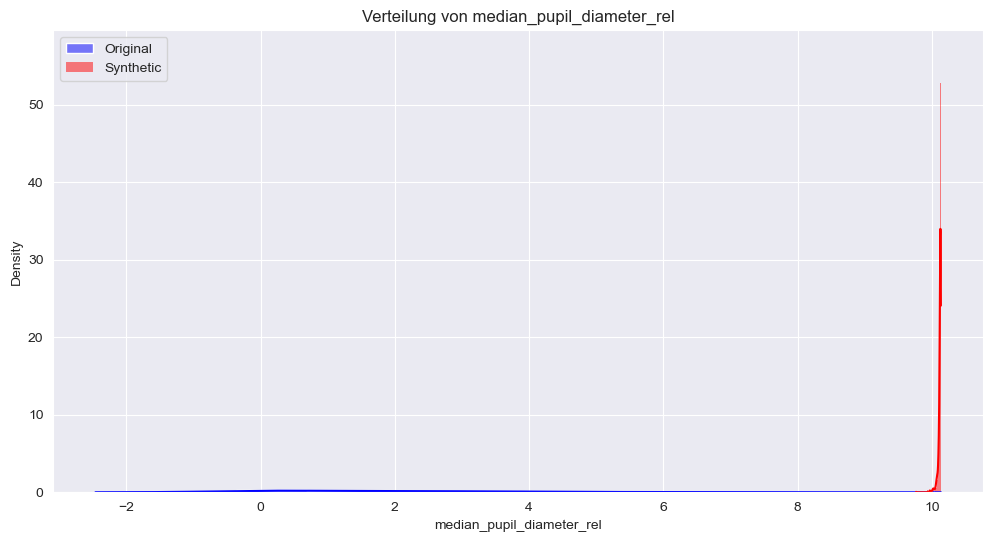

Normalitätstest für median_pupil_diameter_rel:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für median_pupil_diameter_rel:
Statistik = 464.3381269164936, p-Wert = 5.468263645773557e-103
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).



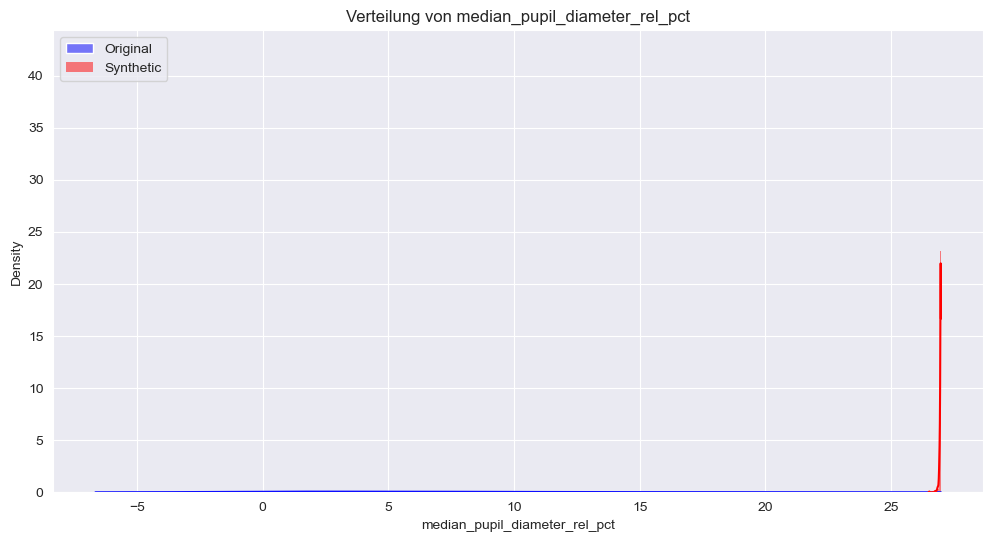

Normalitätstest für median_pupil_diameter_rel_pct:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für median_pupil_diameter_rel_pct:
Statistik = 464.3381418721683, p-Wert = 5.468222667453781e-103
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).



In [12]:

# Konvertiere die augmented_data in ein DataFrame
augmented_df = pd.DataFrame(augmented_data, columns=data.columns)

# Getrennte DataFrames für Original- und generierte Daten
original_df = data.copy()
synthetic_df = augmented_df.iloc[len(data):].copy()


# Datenüberprüfung
Util.data_check.compare_distributions(original_df, synthetic_df)
